In [1]:
import itertools
from typing import List, Optional, Tuple, Union, Dict

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from utils import ugv_utils as ugvu
from visualization import papermode

papermode(plt, size=18)

In [2]:
abbrs = [*u.abbrange("M", 1, 8)]
summary = pd.DataFrame({"abbr": abbrs}, index=abbrs)
summary["terrain"] = summary.abbr.apply(u.get_terrain)
fname = summary.abbr.apply(u.get_filename)
summary["motion"] = fname.apply(lambda a: "lin" if "Lin" in a else "rot")
dfs = {ab: ugvu.read_df_rename_columns(ab) for ab in abbrs}
times = [dfs[a].time.to_numpy() for a in summary.abbr]
lengths = [t.max() - t.min() for t in times]
summary["length"] = lengths

for abbr in abbrs:
    print(abbr, u.get_filename(abbr))

M01 M01_2022-09-14-19-01-10-AP-LinParking01_elec
M02 M02_2022-09-14-19-05-20-AP-LinParking02_elec
M03 M03_2022-09-14-19-09-59-AP-RotParkingCCW01_elec
M04 M04_2022-09-14-19-13-56-AP-RotParkingCW02_elec
M05 M05_2022-09-12-15-14-00-GD-RotDumpCCW01_elec
M06 M06_2022-09-12-15-16-51-GD-RotDumpCCW02_elec
M07 M07_2022-09-12-15-08-14-GD-LinDump_elec


In [3]:
summary

abbr  terrain motion      length
M01  M01  asphalt    lin  100.703029
M02  M02  asphalt    lin  188.264760
M03  M03  asphalt    rot  186.286541
M04  M04  asphalt    rot  195.354517
M05  M05   gravel    rot   70.455426
M06  M06   gravel    rot  133.856100
M07  M07   gravel    lin  195.156146

In [4]:
for abbr in summary.abbr:
    preprocess(abbr, verbose=False)

In [5]:
selected_abbrs = ("M01", "M02", "M03", "M04", "M05", "M03")
selection = pd.DataFrame({"abbr":selected_abbrs})

In [6]:
dfs = tuple(ugvu.read_df_rename_columns(ab) for ab in selection.abbr)
big_df = ugvu.append_dfs(dfs)

m2009_df = big_df.copy()
m2009_df.meta = big_df.meta
p2014_df = big_df.copy()
p2014_df.meta = big_df.meta
p2022_df = big_df.copy()
p2022_df.meta = big_df.meta

m2009_df = morales2009.morales2009(
    abbr=m2009_df.meta.abbr,
    df=m2009_df,
    verbose=False,
    compute_errors=False,
)
p2014_df = pentzer2014pow.pentzer2014pow(
    abbr=p2014_df.meta.abbr,
    df=p2014_df,
    verbose=False,
    compute_errors=False,
)
p2022_df = pentzer2022.pentzer2022(
    abbr=p2022_df.meta.abbr,
    df=p2022_df,
    verbose=False,
    compute_errors=False,
    detect_terrains=True,
)


M01M02M03M04M05M03: 100%|██████████| 922/922 [00:00<00:00, 3472.66it/s]


In [7]:
selection["st"] = [big_df[big_df.run_idx == i].time_rel.head(1).item() for i in selection.index]
selection["en"] = [big_df[big_df.run_idx == i].time_rel.tail(1).item() for i in selection.index]
selection["divi"] = (selection.st.shift(-1) + selection.en) / 2

selection["terrain"] = [summary.terrain.loc[abbr] for abbr in selection.abbr]

In [8]:
def add_terrain_legend(
    mpl_elem: Union[mpl.axes.Axes, mpl.figure.Figure],
    terr_colors : Dict[str,str],
    highlighted: Optional[List[str]] = None,
    layout: str = "vertical",
    alpha: Optional[float] = None,
):
    legend_handles = [mpatches.Patch(color=col, label=lab.title(), alpha=alpha or 1) for lab, col in terr_colors.items()]
    if highlighted is not None:
        legend_handles.extend([mpatches.Patch(color="xkcd:bright red", label=lab, alpha=alpha or 1) for lab in highlighted])
    # mpl_elem.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0), loc="lower left")
    if layout.lower == "vertical":
        mpl_elem.legend(
            handles=legend_handles,
            bbox_to_anchor=(1, 0.5),
            loc="center left",
            title="Terrain",
        )
    else:
        mpl_elem.legend(
            handles=legend_handles,
            ncol=len(terr_colors),
            bbox_to_anchor=(0.5, 0.05),
            loc="upper center",
            title="Terrain",
        )

# Figures

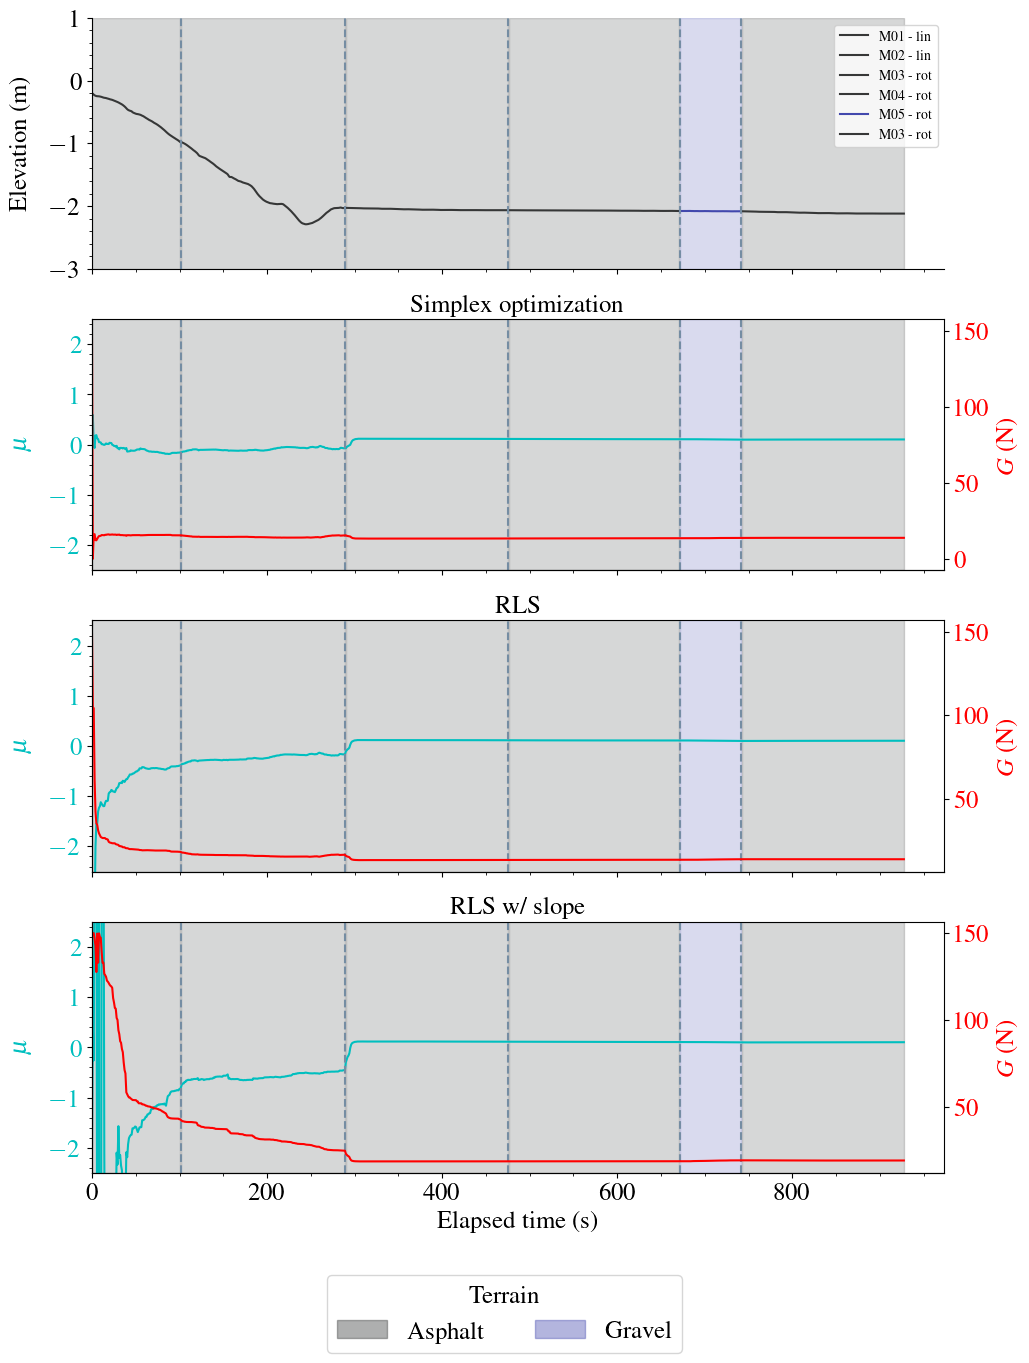

In [9]:
fig, axs = plt.subplots(figsize=(11, 15), nrows=4, sharex=True)

for idx, abbr in enumerate(selection.abbr):
    abbr_mask = m2009_df.run_idx == idx
    abbr_info = summary.loc[abbr]
    abbrlab = label = f"{abbr} - {abbr_info.motion}"
    axs[0].plot(m2009_df[abbr_mask].time_rel, m2009_df[abbr_mask].pz, label=abbrlab, color=u.COLORS[abbr_info.terrain])
axs[0].set_ylabel("Elevation (m)")
axs[0].yaxis.set_label_coords(-0.07, 0.5)
axs[0].set_ylim(bottom=-3, top=1)
axs[0].legend(fontsize=10)

axs[1].plot(m2009_df.time_rel, m2009_df.m_sym, c="c")
axs[1].set_ylabel("$\mu$", c="c")
axs[1].yaxis.set_label_coords(-0.07, 0.5)
axs[1].set_ylim(bottom=-2.5, top=2.5)
axs[1].yaxis.set_tick_params(labelcolor="c")
ax_right = axs[1].twinx()
ax_right.plot(m2009_df.time_rel, m2009_df.G_sym, c="r")
ax_right.set_ylabel("$G$ (N)", color="r")
ax_right.tick_params(axis="y", labelcolor="r")
axs[1].set_title("Simplex optimization")

axs[2].plot(p2014_df.time_rel, p2014_df.m_sym, c="c")
axs[2].set_ylabel("$\mu$", c="c")
axs[2].yaxis.set_label_coords(-0.07, 0.5)
axs[2].set_ylim(bottom=-2.5, top=2.5)
axs[2].yaxis.set_tick_params(labelcolor="c")
ax_right = axs[2].twinx()
ax_right.plot(p2014_df.time_rel, p2014_df.G_sym, c="r")
ax_right.set_ylabel("$G$ (N)", color="r")
ax_right.tick_params(axis="y", labelcolor="r")
axs[2].set_title("RLS")

axs[3].plot(p2022_df.time_rel, p2022_df.m_sym, c="c")
axs[3].set_ylabel("$\mu$", c="c")
axs[3].yaxis.set_label_coords(-0.07, 0.5)
axs[3].set_ylim(bottom=-2.5, top=2.5)
axs[3].yaxis.set_tick_params(labelcolor="c")
ax_right = axs[3].twinx()
ax_right.plot(p2022_df.time_rel, p2022_df.G_sym, c="r")
ax_right.set_ylabel("$G$ (N)", color="r")
ax_right.tick_params(axis="y", labelcolor="r")
axs[3].set_title("RLS w/ slope")

axs[3].set_xlabel("Elapsed time (s)")
axs[3].xaxis.set_label_coords(0.5, -0.15)
axs[3].set_xlim(left=0)

for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    for div in selection.divi.dropna():
        ax.axvline(x=div, color="xkcd:blue/grey", linestyle="--")

    for idx, row in selection.iterrows():
        ax.axvspan(row.st, row.en, color=u.COLORS[row.terrain], alpha=0.2)

terr_cols = {terr: u.COLORS[terr] for terr in summary.terrain.unique()}
add_terrain_legend(fig, terr_cols, alpha=0.4)
# subfigs[0].set_facecolor("coral")
# subfigs[1].set_facecolor("xkcd:blue/grey")


# for ext in u.EXTS:
#     fig.savefig(figdir / f"warthog-hill.{ext}", bbox_inches="tight")

In [10]:

m2009_df["Pest"] = m2009_df.m_sym * m2009_df.JS_sym + m2009_df.G_sym * m2009_df.JG
m2009_df["Perr"] = m2009_df.P_motion - m2009_df.Pest

p2014_df["Pest"] = p2014_df.m_sym * p2014_df.JS_sym + p2014_df.G_sym * p2014_df.JG
p2014_df["Perr"] = p2014_df.P_motion - p2014_df.Pest

p2022_df["Pest"] = p2022_df.m_sym * p2022_df.JS_sym + p2022_df.G_sym * p2022_df.JG
p2022_df["Perr"] = p2022_df.P_motion - p2022_df.Pest

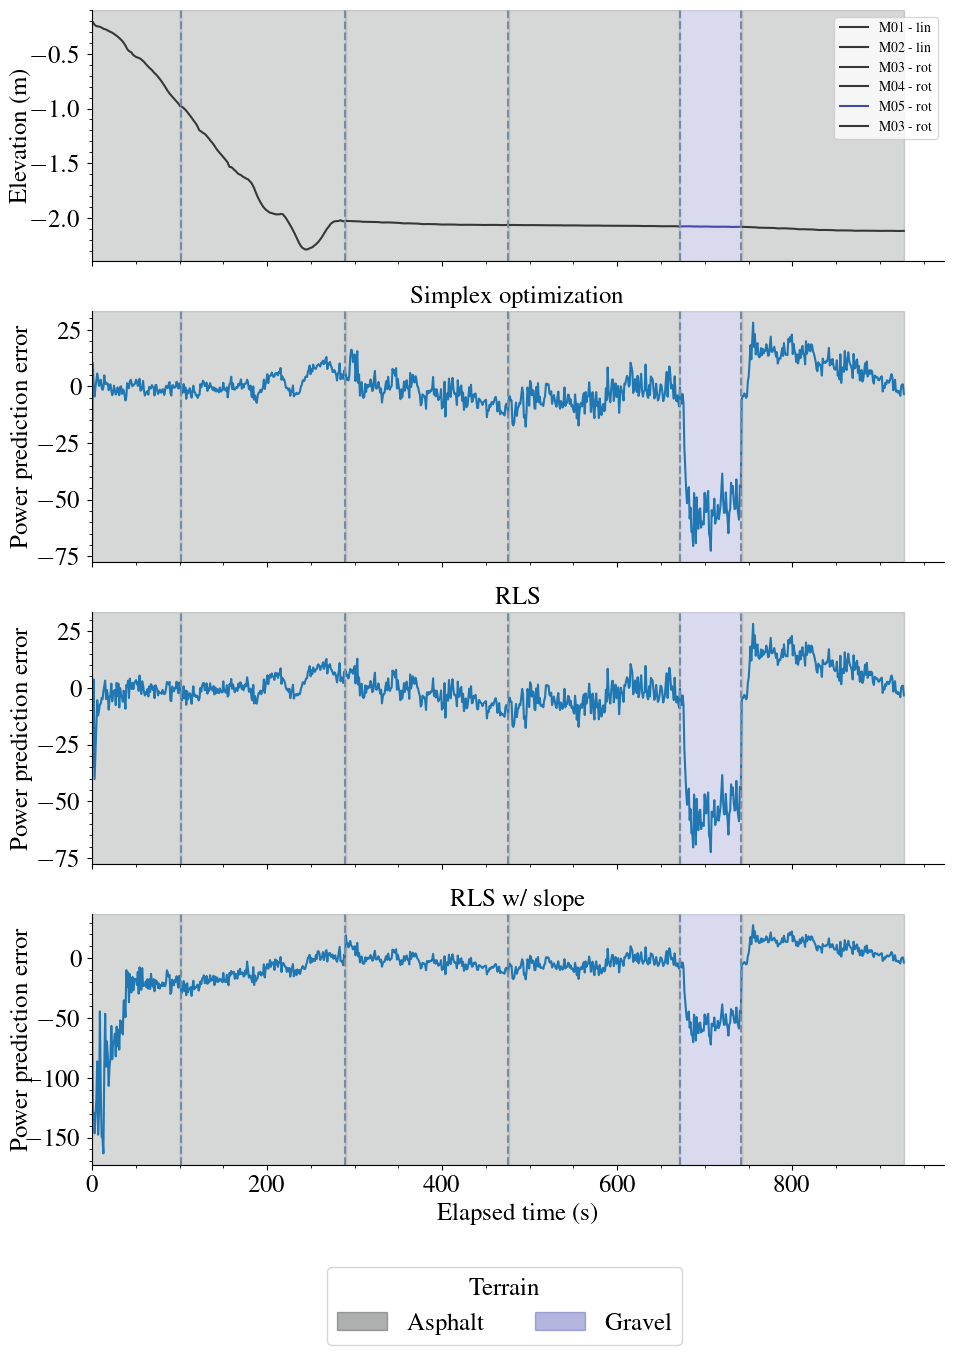

In [11]:
fig, axs = plt.subplots(figsize=(11, 15), nrows=4, sharex=True)

for idx, abbr in enumerate(selection.abbr):
    abbr_mask = m2009_df.run_idx == idx
    abbr_info = summary.loc[abbr]
    abbrlab = label = f"{abbr} - {abbr_info.motion}"
    axs[0].plot(m2009_df[abbr_mask].time_rel, m2009_df[abbr_mask].pz, label=abbrlab, color=u.COLORS[abbr_info.terrain])
axs[0].set_ylabel("Elevation (m)")
axs[0].yaxis.set_label_coords(-0.07, 0.5)
# axs[0].set_ylim(bottom=-3, top=1)
axs[0].legend(fontsize=10)

axs[1].plot(m2009_df.time_rel, m2009_df.Perr)
axs[1].set_ylabel("Power prediction error")
axs[1].yaxis.set_label_coords(-0.07, 0.5)
# axs[1].set_ylim(bottom=-2.5, top=2.5)
axs[1].set_title("Simplex optimization")

axs[2].plot(p2014_df.time_rel, p2014_df.Perr)
axs[2].set_ylabel("Power prediction error")
axs[2].yaxis.set_label_coords(-0.07, 0.5)
# axs[2].set_ylim(bottom=-2.5, top=2.5)
axs[2].set_title("RLS")

axs[3].plot(p2022_df.time_rel, p2022_df.Perr)
axs[3].set_ylabel("Power prediction error")
axs[3].yaxis.set_label_coords(-0.07, 0.5)
# axs[3].set_ylim(bottom=-2.5, top=2.5)
axs[3].set_title("RLS w/ slope")

axs[3].set_xlabel("Elapsed time (s)")
axs[3].xaxis.set_label_coords(0.5, -0.15)
axs[3].set_xlim(left=0)

for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    for div in selection.divi.dropna():
        ax.axvline(x=div, color="xkcd:blue/grey", linestyle="--")

    for idx, row in selection.iterrows():
        ax.axvspan(row.st, row.en, color=u.COLORS[row.terrain], alpha=0.2)

terr_cols = {terr: u.COLORS[terr] for terr in summary.terrain.unique()}
add_terrain_legend(fig, terr_cols, alpha=0.4)


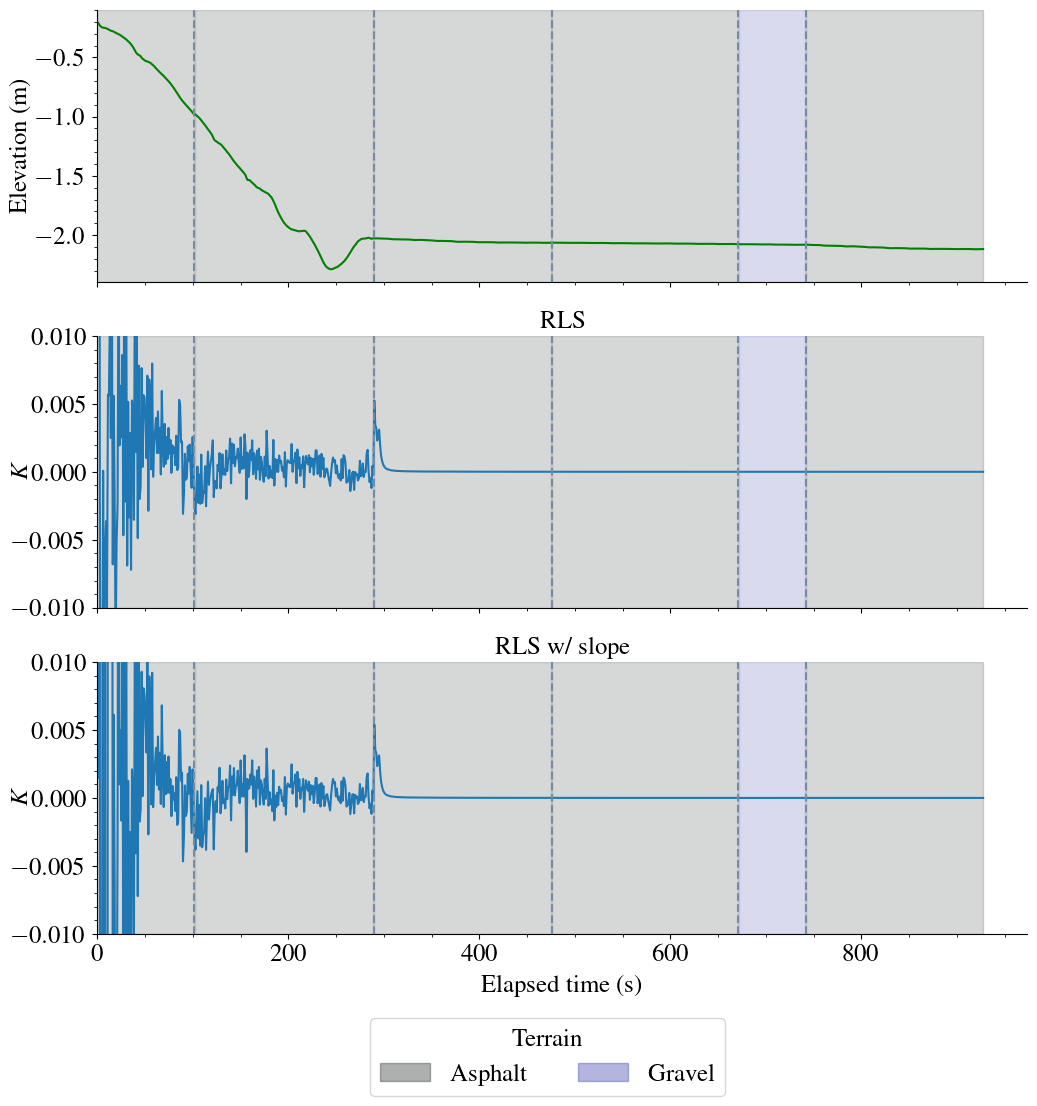

In [12]:
fig, axs = plt.subplots(figsize=(12, 12), nrows=3, sharex=True)

axs[0].plot(m2009_df.time_rel, m2009_df.pz, "g")
axs[0].set_ylabel("Elevation (m)")
axs[0].yaxis.set_label_coords(-0.07, 0.5)

axs[1].plot(p2014_df.time_rel, p2014_df.Km_sym)
axs[1].set_ylabel("$K$")
axs[1].yaxis.set_label_coords(-0.07, 0.5)
axs[1].set_ylim(bottom=-0.01, top=0.01)
axs[1].set_title("RLS")

axs[2].plot(p2022_df.time_rel, p2022_df.Km_sym)
axs[2].set_ylabel("$K$")
axs[2].yaxis.set_label_coords(-0.07, 0.5)
axs[2].set_ylim(bottom=-0.01, top=0.01)
axs[2].set_title("RLS w/ slope")

axs[2].set_xlabel("Elapsed time (s)")
axs[2].xaxis.set_label_coords(0.5, -0.15)
axs[2].set_xlim(left=0)

for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    for div in selection.divi.dropna():
        ax.axvline(x=div, color="xkcd:blue/grey", linestyle="--")

    for idx, row in selection.iterrows():
        ax.axvspan(row.st, row.en, color=u.COLORS[row.terrain], alpha=0.2)

terr_cols = {terr: u.COLORS[terr] for terr in summary.terrain.unique()}
add_terrain_legend(fig, terr_cols, alpha=0.4)

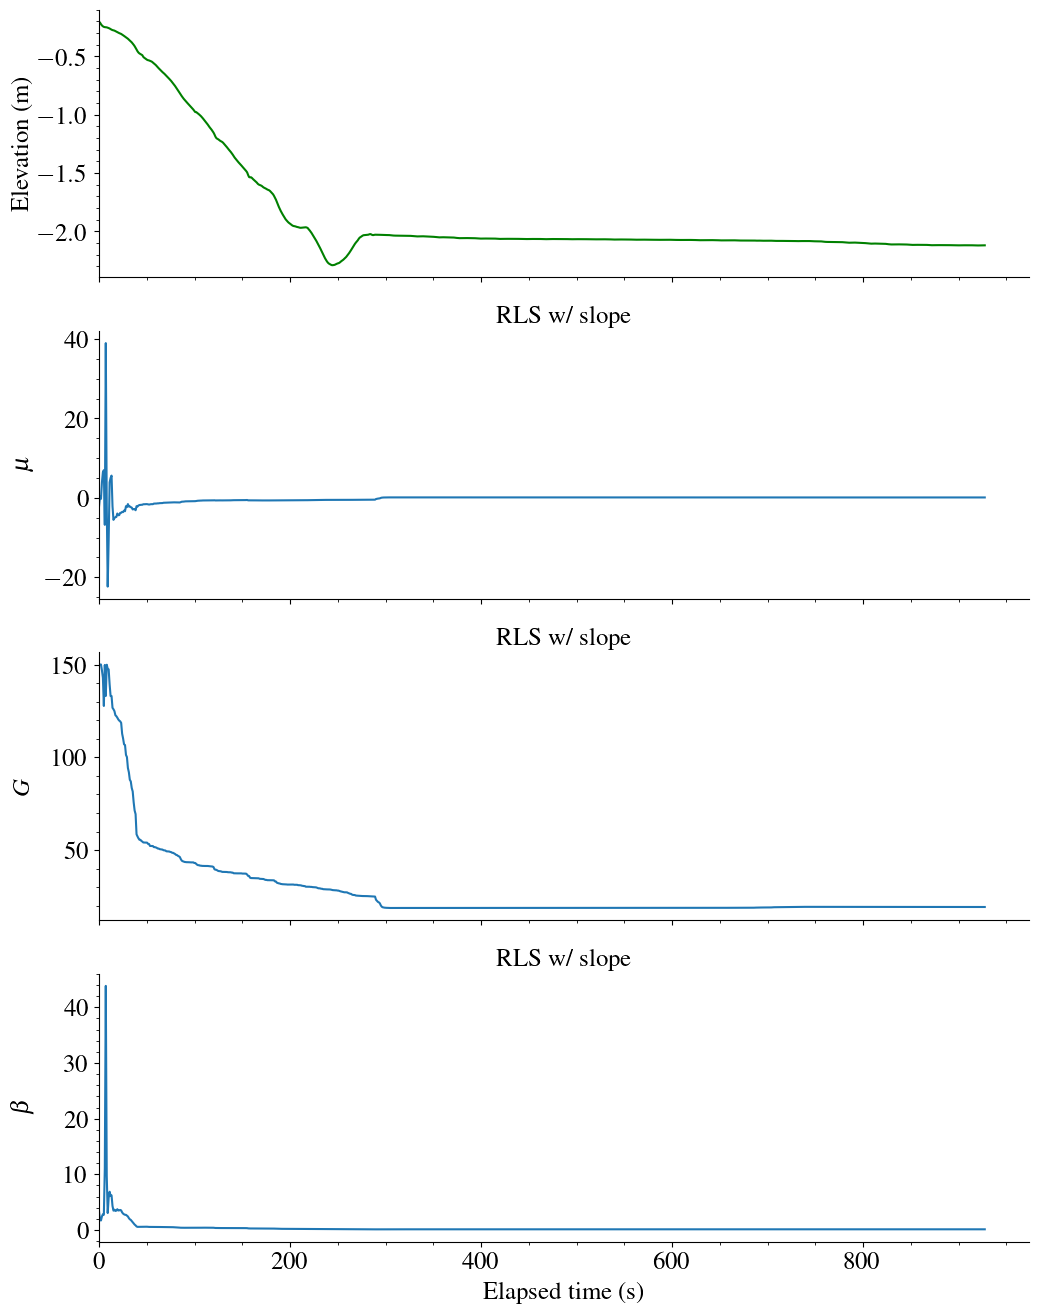

In [13]:
fig, axs = plt.subplots(figsize=(12, 16), nrows=4, sharex=True)

axs[0].plot(m2009_df.time_rel, m2009_df.pz, "g")
axs[0].set_ylabel("Elevation (m)")
axs[0].yaxis.set_label_coords(-0.07, 0.5)

axs[1].plot(p2022_df.time_rel, p2022_df.m_sym)
axs[1].set_ylabel("$\mu$")
axs[1].yaxis.set_label_coords(-0.07, 0.5)
# axs[1].set_ylim(bottom=-2.5, top=2.5)
axs[1].set_title("RLS w/ slope")

axs[2].plot(p2022_df.time_rel, p2022_df.G_sym)
axs[2].set_ylabel("$G$")
axs[2].yaxis.set_label_coords(-0.07, 0.5)
# axs[2].set_ylim(bottom=-2.5, top=2.5)
axs[2].set_title("RLS w/ slope")

axs[3].plot(p2022_df.time_rel, p2022_df.B_sym)
axs[3].set_ylabel("$\\beta$")
axs[3].yaxis.set_label_coords(-0.07, 0.5)
# axs[3].set_ylim(bottom=-2.5, top=2.5)
axs[3].set_title("RLS w/ slope")

axs[3].set_xlabel("Elapsed time (s)")
axs[3].xaxis.set_label_coords(0.5, -0.15)
axs[3].set_xlim(left=0)

for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())